# Feedforward Neural Network on the Iris Dataset
# Using Pipeline API

Fisher's Iris dataset  

We are going to try the same Iris dataset as on feedforward-iris.ipynb, but this time using
Spark MLLib's Pipeline-based API.

This dataset contains 150 samples, with 4 dimensions, as follows:

1. Petal Length  (c1)
2. Petal Width   (c2)
3. Sepal Length  (c3)
4. Sepal Width   (c4)

There are 3 output classes: Setosa, Versicolor, and Virginica.
In our output datset, we have simplified this data by making classes simply 1, 2, 3.

Here's an example of what the dataset looks like

| c1  | c2  | c3  | c4  | label | 
|-----|-----|-----|-----|-------| 
| 6.4 | 2.8 | 5.6 | 2.2 | 3     | 
| 5.0 | 2.3 | 3.3 | 1.0 | 2     | 
| 4.9 | 2.5 | 4.5 | 1.7 | 3     | 
| 4.9 | 3.1 | 1.5 | 0.1 | 1     | 
| 5.7 | 3.8 | 1.7 | 0.3 | 1     | 
| 4.4 | 3.2 | 1.3 | 0.2 | 1     | 
| 5.4 | 3.4 | 1.5 | 0.4 | 1     | 
| 6.9 | 3.1 | 5.1 | 2.3 | 3     | 
| 6.7 | 3.1 | 4.4 | 1.4 | 2     | 



In [1]:
%matplotlib inline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import pandas as pd
import random as rd
import datetime as dt 



from bigdl.dataset.transformer import *
from bigdl.dataset.base import *
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from utils import *
from bigdl.models.ml_pipeline.dl_classifier import *

from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, udf
from pyspark.ml import  Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


init_engine()

## Parameters

These are parameters that can be changed:

Explanation:

1. Learning Rate:  This indicates the "step size" of the gradient descent-type optimization functions. The larger the step size, the less of a chance of getting caught in a local minimum but too large may lead to very poor results.

2. Training Epochs: the number of cycles of training that we use.

3. Batch size: The size of the batch (with replacement) that we take per training iteration.

4. N_input: Number of input dimensions

5. N_Classes: Number of output classes for classification problem.

6. N_Hidden_1: Number of hidden layer neurons.

In [2]:
learning_rate = 0.1
training_epochs = 100
batch_size = 16
display_step = 1

# Network Parameters
n_input = 4
n_classes = 3
n_hidden = 3 # 1st layer number of features


### Sizing the Hidden Layer(s)

Sizing hidden layers can be a challenge.  The best way to figure this out is to do it
empirically.  However, we may need a "rule of thumb" to start.  Here is a good rule of thumb:

First Hidden Layer:
```
n_hidden_1 = np.sqrt(np.sqrt((n_classes + 2) * n_input) + 2 * np.sqrt(n_input /(n_classes+2.)))
```

Second Hidden Layer:  (if needed)
```
n_hidden_2 = n_classes * np.sqrt(n_input / (n_classes + 2.))
```

In this case, we have a **VERY** simple dataset.  We may not need two hidden layers. Let's see what we have.


In [3]:
# Number of hidden layers

n_hidden_guess = np.sqrt(np.sqrt((n_classes + 2) * n_input) + 2 * np.sqrt(n_input /(n_classes+2.)))
print("Hidden layer 1 (Guess) : " + str(n_hidden_guess))

n_hidden_guess_2 = n_classes * np.sqrt(n_input / (n_classes + 2.))
print("Hidden layer 2 (Guess) : " + str(n_hidden_guess_2))



Hidden layer 1 (Guess) : 2.50219710195
Hidden layer 2 (Guess) : 2.683281573


## Result

Each hidden layer should around 2-3 input neurons.

np.sqrt(np.sqrt((n_classes+2) * n_input) + 2 * np.sqrt(n_input /(n_classes+2)))
#and in the second hidden layer, the optimal number of hidden nodes is: m*sqrt[N/(m+2)],
n_classes * np.sqrt(n_input / (n_classes + 2.))


## Load the Data

Let's load the data into Spark Dataframes, and we'll cast everything to be double.

In [4]:
iris_training = spark.read.csv("../data/iris/iris_training.csv", header=True, inferSchema="true", mode="DROPMALFORMED")
iris_test = spark.read.csv("../data/iris/iris_test.csv", header=True, inferSchema="true", mode="DROPMALFORMED")

In [5]:
iris_training = iris_training.select([col(c).cast("double") for c in iris_training.columns])
iris_test = iris_test.select([col(c).cast("double") for c in iris_test.columns])



## Setting up a Spark MLlib pipeline

We will use a Spark MLLib pipeline to do two things:

1. Extract a feature vector into a new column called "assembled" (using VectorAssembler).
2. Use StandardScaler to scale the vector values by mean and unit variance.

In [6]:
assembler =  VectorAssembler(inputCols=['c1','c2','c3','c4'], outputCol="assembled")
scaler = StandardScaler(inputCol="assembled", outputCol="features")
pipeline = Pipeline(stages = [assembler, scaler])
pipelineTraining = pipeline.fit(iris_training)
iris_data_training = pipelineTraining.transform(iris_training)
pipelineTest = pipeline.fit(iris_test)
iris_data_test = pipelineTraining.transform(iris_test)

In [28]:
iris_data_training.select('features', 'label').show(10, False)

+----------------------------------------------------------------------------+-----+
|features                                                                    |label|
+----------------------------------------------------------------------------+-----+
|[7.3683612551017434,6.554983394668502,3.07337626655598,2.813157930275381]   |3.0  |
|[5.7565322305482365,5.384450645620555,1.8110967285062027,1.2787081501251731]|2.0  |
|[5.641401585937273,5.8526637452397345,2.469677357053913,2.1738038552127943] |3.0  |
|[5.641401585937273,7.257303044097271,0.8232257856846377,0.12787081501251732]|1.0  |
|[6.56244674282499,8.896048892764396,0.9329892237759226,0.38361244503755193] |1.0  |
|[5.065748362882449,7.491409593906861,0.7134623475933526,0.25574163002503464]|1.0  |
|[6.2170548089920965,7.959622693526039,0.8232257856846377,0.5114832600500693]|1.0  |
|[7.944014478156568,7.257303044097271,2.798967671327768,2.941028745287898]   |3.0  |
|[7.713753188934637,7.257303044097271,2.4147956380082705,1.790191

### Use the Pipeline API to set up neural network classifier

We will now use the Pipeline API to set up a neural network classifier. The parameters and results are very similar to the previous example, but this time around we are using the pipeline API.

This is totally integrated with our existing Spark ML workflows!  

In [29]:

bigDLModel = Sequential().add(Linear(n_input, n_hidden)).add(Linear(n_hidden, n_classes)).add(LogSoftMax())
classnll_criterion = ClassNLLCriterion()
dlClassifier = DLClassifier(model=bigDLModel, criterion=classnll_criterion, feature_size=[n_input])
dlClassifier.setLabelCol("label").setMaxEpoch(training_epochs).setBatchSize(16).setLearningRate(learning_rate)
model = dlClassifier.fit(iris_data_training)
print("\ninitial model training finished.")

creating: createSequential
creating: createLinear
creating: createLinear
creating: createLogSoftMax
creating: createClassNLLCriterion
creating: createDLClassifier

initial model training finished.


In [30]:
# Coerce the outpu to be a Dataframe object -- return object is a JavaObject by defaul.

from pyspark.sql import DataFrame, SQLContext
predictionDF = DataFrame(model.transform(iris_data_test), SQLContext(sc))
predictionDF

DataFrame[c1: double, c2: double, c3: double, c4: double, label: double, assembled: vector, features: vector, prediction: double]

In [31]:
predictionDF.show()

+---+---+---+---+-----+-----------------+--------------------+----------+
| c1| c2| c3| c4|label|        assembled|            features|prediction|
+---+---+---+---+-----+-----------------+--------------------+----------+
|5.9|3.0|4.2|1.5|  2.0|[5.9,3.0,4.2,1.5]|[6.79270803204692...|       2.0|
|6.9|3.1|5.4|2.1|  3.0|[6.9,3.1,5.4,2.1]|[7.94401447815656...|       3.0|
|5.1|3.3|1.7|0.5|  1.0|[5.1,3.3,1.7,0.5]|[5.87166287515920...|       1.0|
|6.0|3.4|4.5|1.6|  2.0|[6.0,3.4,4.5,1.6]|[6.90783867665788...|       2.0|
|5.5|2.5|4.0|1.3|  2.0|[5.5,2.5,4.0,1.3]|[6.33218545360306...|       2.0|
|6.2|2.9|4.3|1.3|  2.0|[6.2,2.9,4.3,1.3]|[7.13809996587981...|       2.0|
|5.5|4.2|1.4|0.2|  1.0|[5.5,4.2,1.4,0.2]|[6.33218545360306...|       1.0|
|6.3|2.8|5.1|1.5|  3.0|[6.3,2.8,5.1,1.5]|[7.25323061049077...|       2.0|
|5.6|3.0|4.1|1.3|  2.0|[5.6,3.0,4.1,1.3]|[6.44731609821402...|       2.0|
|6.7|2.5|5.8|1.8|  3.0|[6.7,2.5,5.8,1.8]|[7.71375318893463...|       3.0|
|7.1|3.0|5.9|2.1|  3.0|[7.1,3.0,5.9,2.

## Evaluate the Model

Calculate Precision, Recall and the Area Under the Precision / Recall curve.


In [32]:
predictionDF.cache()
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
auPRC = evaluator.evaluate(predictionDF)
print("\nArea under precision-recall curve: = " + str(auPRC))
    
recall = MulticlassClassificationEvaluator(metricName="weightedRecall").evaluate(predictionDF)
print("\nrecall = " + str(recall))

precision = MulticlassClassificationEvaluator(metricName="weightedPrecision").evaluate(predictionDF)
print("\nPrecision = " + str(precision))
predictionDF.unpersist()


Area under precision-recall curve: = 1.0

recall = 0.933333333333

Precision = 0.933333333333


DataFrame[c1: double, c2: double, c3: double, c4: double, label: double, assembled: vector, features: vector, prediction: double]

## More evaluations: Accuracy and Confusion Matrix

Use predict on the validation dataset, and then calcualte the accuracy and the
confusion matrix.

In [33]:
y_pred = np.array(predictionDF.select('prediction').collect())
y_true = np.array(predictionDF.select('label').collect())

The prediction accuracy is 93.33%


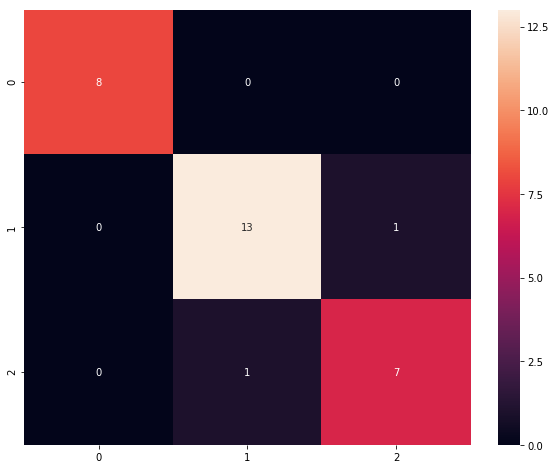

In [34]:
acc = accuracy_score(y_true, y_pred)
print("The prediction accuracy is %.2f%%"%(acc*100))

cm = confusion_matrix(y_true, y_pred)
cm.shape
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt='d');